In [1]:
# !pip install tensorflow_similarity

In [2]:
import numpy as np
import tensorflow as tf
import scipy as scp
import sklearn as skl
# from tensorflow_similarity.models import SimilarityModel

In [51]:
n = 10000

scale = 3 
mu1 = scale*np.array([-1.5396,-1.5396])
sigma1 = np.array([[0.5,0],[0,2]])

mu2 = scale*np.array([0,1])
sigma2 = np.array([[3,0],[0,1/3]])

mu3 = scale*np.array([1.5396,-1.5396])
sigma3 = np.array([[1,0],[0,1]])

x1 = np.random.multivariate_normal(mean = mu1, cov = sigma1, size = n)
y1 = np.array([[1.0,0.0,0.0] for i in range(n)])

x2 = np.random.multivariate_normal(mean = mu2, cov = sigma2, size = n)
y2 = np.array([[0.0,1.0,0.0] for i in range(n)])

x3 = np.random.multivariate_normal(mean = mu3, cov = sigma3, size = n)
y3 = np.array([[0.0,0.0,1.0] for i in range(n)])


X = np.concatenate([x1,x2,x3])
Y = np.concatenate([y1,y2,y3])

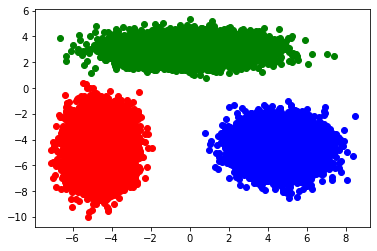

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x1[:,0],x1[:,1], c = "red")
plt.scatter(x2[:,0],x2[:,1], c = "green")
plt.scatter(x3[:,0],x3[:,1], c = "blue")
plt.show()

In [5]:
def augmentation1(x):
    return x+np.random.multivariate_normal(mean = np.array([0,0]), cov = np.array([[1,0],[0,1]]), size = x.reshape((-1,2)).shape[0])
    
def augmentation2(x):
    return np.multiply(x,[2,-1])+1/3

In [6]:
x1[0]

array([-5.93523156, -2.51711529])

In [7]:
augmentation1(x1[0])

array([[-6.0143145 , -1.72933024]])

In [8]:
augmentation2(x1[0])

array([-11.53712978,   2.85044862])

In [9]:
x1_aug1 = augmentation1(x1)

x2_aug1 = augmentation1(x2)

x3_aug1 = augmentation1(x3)

X_aug1 = np.concatenate([x1_aug1,x2_aug1,x3_aug1])

In [10]:
x1_aug2 = augmentation2(x1)

x2_aug2 = augmentation2(x2)

x3_aug2 = augmentation2(x3)

X_aug2 = np.concatenate([x1_aug2,x2_aug2,x3_aug2])

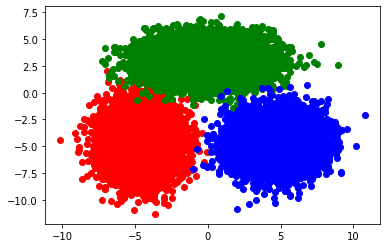

In [11]:
plt.scatter(x1_aug1[:,0],x1_aug1[:,1], c = "red")
plt.scatter(x2_aug1[:,0],x2_aug1[:,1], c = "green")
plt.scatter(x3_aug1[:,0],x3_aug1[:,1], c = "blue")
plt.show()

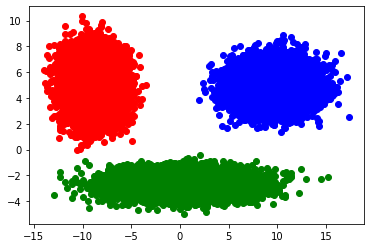

In [12]:
plt.scatter(x1_aug2[:,0],x1_aug2[:,1], c = "red")
plt.scatter(x2_aug2[:,0],x2_aug2[:,1], c = "green")
plt.scatter(x3_aug2[:,0],x3_aug2[:,1], c = "blue")
plt.show()

In [13]:
def softmax_stable(x, axis = None):
    return(np.exp(x - np.max(x, axis =  axis)) / np.exp(x - np.max(x,axis =  axis)).sum())

def naiv_unif_prior_crossentropy(y_preds):
    s1 = softmax_stable(y_preds[0])
    s2 = softmax_stable(y_preds[1])
    
    l1 = -np.sum(s2 * np.log(s1))
    l2 = -np.sum(s1 * np.log(s2))
    
    return  ( l1 + l2 ) / 2

def tf_naiv_unif_prior_crossentropy(y_true, y_preds):
   
    l1 = tf.nn.softmax_cross_entropy_with_logits(labels=y_preds[0],logits=y_preds[1])
    l2 = tf.nn.softmax_cross_entropy_with_logits(labels=y_preds[1],logits=y_preds[0])
    
    return  tf.math.reduce_sum(( l1 + l2 ) / 2)


In [14]:
def unif_prior_crossentropy(y_true,y_preds):
    N, C = y_preds[0].shape 
    pred1 = y_preds[:,0]
    print(pred1)
    pred2 = y_preds[:,1]
    print(pred2)
    t_c = np.sum(pred2,axis=0)
    print(t_c)
    t_r = np.sum(pred1,axis=0)
    print(t_c)
    
    a = softmax_stable(pred2/t_c, axis=0)
    print(a)
    b = np.linalg.norm(a, ord=1,axis=1)
    print(b)
    c = np.reshape(b,(N,-1))
    print(c)
    
    part1 = c
    part2 = np.reshape(np.log(N/C *np.linalg.norm(softmax_stable(pred1/t_r, axis=1), ord=1, axis=0)), (-1,C))
    # print(part1.shape, part2.shape)
    loss_1 = -np.sum( part1 * part2 , axis=-1)

    part1 = np.reshape(np.linalg.norm(softmax_stable(pred1/t_c), ord=1,axis=1),(N,-1))
    part2 = np.reshape(np.log(N/C *np.linalg.norm(softmax_stable(pred2/t_r, axis=1), ord=1, axis=0)),(-1,C))

    loss_2 = -np.sum( part1*part2 , axis=-1)


    return np.mean(1/2*(loss_1+loss_2))

In [122]:
def unif_prior_crossentropy(y_true,y_preds):
    N, C = y_preds[0].shape 
    p1 = y_preds[:,0]
    print("p 1 : ",p1)
    p2 = y_preds[:,1]
    print("p 2 : ",p2)
    t_c = 0.1
    print("t_c : ",t_c)
    t_r = 0.1
    print("t_r : ",t_r)
    eps = 1e-8
    
    def mini_loss(x1,x2):
        s1 = softmax_stable(x1/t_c)
        ns1 = s1.sum(axis = 0)
        print("s1 : ",s1)
        print("ns1 : ",ns1)
        ls1 = np.log(N/C * np.dot(s1,1/ns1))
        s2 = softmax_stable(x2/t_r)
        ns2 = 1/s2.sum(axis = 1)
        print("s2 : ",s2)
        print("ns2 : ",ns2)
        p2 = np.dot(ns2,s2)
        return -np.sum(p2*ls1)
    
    return 1/2*(mini_loss(p1,p2)+mini_loss(p2,p1))
    
    
    

In [16]:
y_preds_test = np.zeros((1,2,3))
y_preds_test[0,0,1] = 1
y_preds_test[0,1,1] = 1

In [17]:
softmax_stable(y_preds_test[0])

array([[0.10597078, 0.28805844, 0.10597078],
       [0.10597078, 0.28805844, 0.10597078]])

In [18]:
np.array(y_preds_test).shape

(1, 2, 3)

In [118]:
unif_prior_crossentropy([],y_preds_test)
,[[0,1,0],[0,1,0]],[[0,1,0],[0,1,0]],[[0,0,1],[0,0,1]]

p 1 :  [[0. 1. 0.]]
p 2 :  [[0. 1. 0.]]
t_c :  0.1
t_r :  0.1
s1 :  [[4.53958078e-05 9.99909208e-01 4.53958078e-05]]
ns1 :  [4.53958078e-05 9.99909208e-01 4.53958078e-05]


<>:2: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?


ValueError: shapes (3,) and (1,3) not aligned: 3 (dim 0) != 1 (dim 0)

In [123]:
y_preds_test = np.array([[[1,0,0],[0,1,0]],[[0,0,1],[0,1,0]]])
unif_prior_crossentropy([],y_preds_test)

p 1 :  [[1 0 0]
 [0 0 1]]
p 2 :  [[0 1 0]
 [0 1 0]]
t_c :  0.1
t_r :  0.1
s1 :  [[4.99954604e-01 2.26979039e-05 2.26979039e-05]
 [2.26979039e-05 2.26979039e-05 4.99954604e-01]]
ns1 :  [4.99977302e-01 4.53958078e-05 4.99977302e-01]
s2 :  [[2.26979039e-05 4.99954604e-01 2.26979039e-05]
 [2.26979039e-05 4.99954604e-01 2.26979039e-05]]
ns2 :  [2. 2.]


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [ ]:
def tf_unif_prior_crossentropy(y_true,y_preds):
    N = len(y_preds[0])
    C = 3
    y_preds = tf.constant(y_preds, dtype=tf.float32)
    
    t_c = tf.math.reduce_sum(y_preds[:,0],axis=0)
    t_r = tf.math.reduce_sum(y_preds[:,1],axis=0)
    
    s11 =  tf.math.sigmoid(tf.transpose(y_preds[:,0])/t_c)
    print(s11)
    s21 = tf.math.sigmoid(tf.transpose(y_preds[:,1])/t_c)
    print(s21)

    s12 = tf.math.sigmoid(y_preds[:,0]/t_r)
    print(s12)
    s22 =tf.math.sigmoid(y_preds[:,1]/t_r)
    print(s22)
    
    log_y_x1 = tf.math.log(N/C * tf.linalg.normalize(s12,ord=1, axis = 1))
    log_y_x2 = tf.math.log(N/C * tf.linalg.normalize(s22,ord=1, axis = 1))

    y_x1 = np.linalg.norm(s11,ord=1, axis = 0)
    y_x2 = np.linalg.norm(s21,ord=1, axis = 0)
#     log_y_x1 = np.log ( N / C * np.linalg.norm(( npsigmoid( s1 / t_r )),axis = 0))
#     log_y_x2 = np.log ( N / C * np.linalg.norm(( npsigmoid( s2 / t_r )),axis = 0))
    
#     y_x1 = np.linalg.norm(( npsigmoid( s1.T / t_c )))
#     y_x2 = np.linalg.norm(( npsigmoid( s2.T / t_c )))
    
    l1 = - tf.math.reduce_sum ( y_x2 * log_y_x1 ) / N
    l2 = - tf.math.reduce_sum ( y_x1 * log_y_x2 ) / N
        
    return  ( l1 + l2 ) / 2

In [ ]:
y_preds_test = np.array([[[0,1,0],[0,1,0]],[[0,0,1],[1,0,0]]])
y_preds_test_1 = np.array([[0,1,0],[0,1,0]])

In [ ]:
tf_unif_prior_crossentropy([],y_preds_test_1)

In [89]:
# class CustomLoss(tf.keras.losses.Loss):
#   def __init__(self):
#     super().__init__()
#   def call(self, y_true, y_pred):
#     return  tf_naiv_unif_prior_crossentropy(y_true, y_pred)
class CustomLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    preds = tf.math.reduce_mean(y_pred, axis = 1)
    return  tf.keras.losses.MeanSquaredError()(y_true = y_true,y_pred=  preds)



def create_model_aux(dropout = 0.3):
    layer_input = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    first_layer = tf.keras.layers.Dense(64, activation = "relu", dtype=tf.float16)(layer_input)
    first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
    first_layer = tf.keras.layers.Dense(64, activation = "relu", dtype=tf.float16)(first_layer)
    first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
    first_layer = tf.keras.layers.Dense(64, activation = "relu", dtype=tf.float16)(first_layer)
    first_layer = tf.keras.layers.Dropout(dropout, dtype=tf.float16)(first_layer)
    output = tf.keras.layers.Dense(3,activation = None, dtype='float32')(first_layer)
    output = tf.keras.layers.Dropout(dropout)(output)
    output = tf.keras.layers.Activation("softmax")(output)
    model = tf.keras.models.Model(inputs=layer_input, outputs= output)
    return model

def model():
    model_shared = create_model_aux()
    input_x1 = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    input_x2 = tf.keras.layers.Input(shape=(2), dtype=tf.float32)
    output_x1 = model_shared(input_x1)
    output_x2 = model_shared(input_x2)
    output = tf.keras.layers.Average()([output_x1, output_x2])
    model = tf.keras.models.Model(inputs=[input_x1,input_x2], outputs = output)
    model.compile(loss="categrocial_crossentropy",metrics=[],optimizer = "Adam")
    return model

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,Y, train_size = 0.8)

In [65]:
batch_size = 512

def make_dummy_data(nb_classes = 3):
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=2*batch_size)
        ds = ds.batch(batch_size=batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
        
        
    X = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_aug1), tf.data.Dataset.from_tensor_slices(X_aug2)))
    y =  tf.data.Dataset.from_tensor_slices(Y)
   

    ds = tf.data.Dataset.zip((X,y))
    ds = configure_for_performance(ds)
    return ds

In [23]:
ds = make_dummy_data()

In [88]:
y_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [91]:
test_model = create_model_aux()
test_model.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer = "Adam")
history = test_model.fit(x = X_train,y = y_train,validation_data = (X_test, y_test),  epochs = 10, steps_per_epoch= int(len(X)/batch_size)+1)

Epoch 1/10
59/59 [==============================] - 1s 17ms/step - loss: 33.9506 - accuracy: 0.5992 - val_loss: 2.9124e-08 - val_accuracy: 1.0000
Epoch 2/10
59/59 [==============================] - 1s 15ms/step - loss: 3.0281 - accuracy: 0.8325 - val_loss: 4.3347e-08 - val_accuracy: 1.0000
Epoch 3/10
59/59 [==============================] - 1s 15ms/step - loss: 1.4500 - accuracy: 0.8718 - val_loss: 3.3776e-10 - val_accuracy: 1.0000
Epoch 4/10
59/59 [==============================] - 1s 14ms/step - loss: 1.0645 - accuracy: 0.8874 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
59/59 [==============================] - 1s 16ms/step - loss: 0.8854 - accuracy: 0.8931 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
59/59 [==============================] - 1s 16ms/step - loss: 0.6166 - accuracy: 0.9038 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
59/59 [==============================] - 1s 13ms/step - loss: 0.5104 - accuracy: 0.9026 - val_loss: 0.0000e+00 - val_a

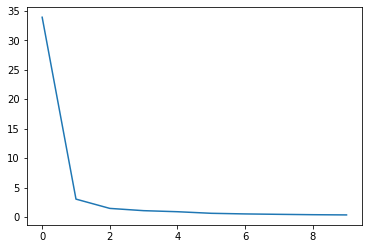

In [92]:
plt.plot(history.history["loss"])

In [83]:
y_predict = test_model.predict(X_test)


In [106]:
y_predict_labels =y_predict[:].argmax(axis = 1)

In [115]:
# X_test[y_predict_labels[:]==2]
x_test_1 = X_test[y_predict_labels[:]==0]
x_test_2 = X_test[y_predict_labels[:]==1]
x_test_3 = X_test[y_predict_labels[:]==2]

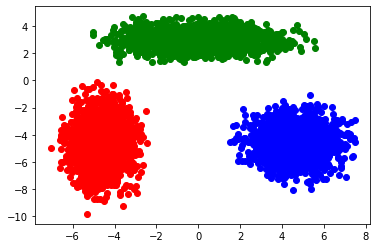

In [116]:
plt.scatter(x_test_1[:,0],x_test_1[:,1], c = "red")
plt.scatter(x_test_2[:,0],x_test_2[:,1], c = "green")
plt.scatter(x_test_3[:,0],x_test_3[:,1], c = "blue")
plt.show()

In [ ]:
batch_size_evaluate = 1024

def make_evaluate_data(nb_classes = 3):
    def configure_for_performance(ds):
        ds = ds.batch(batch_size=batch_size_evaluate)
        ds = ds.prefetch(buffer_size=1024)
        return ds
        
        
    X = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_aug1), tf.data.Dataset.from_tensor_slices(X_aug2)))
    y =  tf.data.Dataset.from_tensor_slices(np.zeros((len(X_aug1),nb_classes)))
   

    ds = tf.data.Dataset.zip((X,y))
    ds = configure_for_performance(ds)
    return ds

ds_eval =  make_evaluate_data()
X_eval = test_model.predict(ds_eval)

In [ ]:
np.unique(X_eval[0], axis = 0)

In [ ]:
X[X_eval[0][:]==[1,0,0]]

In [ ]:
x_eval_1 = np.array([X[:,0][X_eval[0][:]==[1,0,0]],X[:,1][X_eval[0][:]==[1,0,0]]]).reshape((-1,2))

In [ ]:
x_eval_1

In [ ]:
plt.scatter(X_eval[0][X_eval[0][:]==[1,0,0]],X_eval[1][], c = "red")
plt.scatter(x2_aug2[:,0],x2_aug2[:,1], c = "green")
plt.scatter(x3_aug2[:,0],x3_aug2[:,1], c = "blue")
plt.show()